# 1st project
Author: *Zigfrid Zvezdin*  
Tutor: *Dmitri Kamzolov*  
Special thanks to: *Meruza Kubentaeva*

## Introduction
### Goals
At this project we were supposed to implement algorithms from [Primal-dual accelerated gradient methods with small-dimensional relaxation oracle](https://arxiv.org/abs/1809.05895) paper and apply it to [Anaheim transport network](https://github.com/bstabler/TransportationNetworks) with Beckmann model. However, due to the nature of the algorithm we were not able to do this, so we finished by developing another algorithm.
### Work on the project
The idea was to take [Meruza's project](https://github.com/MeruzaKub/TransportNet) and add an implementation of the Universal Accelerated Gradient Method with Small-Dimensional Relaxation (UAGMsDR).  
During the work on the project, some technical issues were encountered:
1. **Problem**: difficulties installing the essential for the project [Graph tool library](https://graph-tool.skewed.de/). **Solution**: creating a Docker image based on [Graph tool Docker image](https://git.skewed.de/count0/graph-tool/wikis/installation-instructions).
2. **Problem**: a newer version of Graph tool caused non-compilation of the code in the repo. The first found fix of the problem actually did not fix the problem. **Solution**: Compare the versions of the library and find how some specific functions changed.

## Algorithm
Basic algorithm UAGMsDR from paper works only with L-smooth functions without composite non-smooth part and without constraints. So we can't directly use it for our problem. Firstly, we add prox part to dual averaging step 7. But the main problem is the gradient step 4. We may add a gradient of a composite part, but then we will lose composite structure. So we try to test some fixed constant steps numerically, and fortunately, we found a well numerically converging algorithm.

**Input**: Accuracy $\epsilon$, constants $\beta$ and $h$  
**Output**: $x^k$
1. Set $k=0, A_0=0, x^0=v^0, \psi_0(x)=V(x,x^0)$
2. **for $k \geq 0$ do**
3. $y^k = v^k + \beta_k(x^k-v^k)$
4. $x^{k+1} = y^k - h_{k+1}\nabla f(y^k)$. Find $a_{k+1}$ from equation $f(y^k) - \frac{a_{k+1}^2}{2(A_k+a_{k+1})}||\nabla f(y^k)||^2+\frac{\epsilon a_{k+1}}{2(A_k+a_{k+1})} = f(x^{k+1})$
5. Set $A_{k+1} = A_k + a_{k+1}$.
6. Set $\psi_{k+1} = \psi_k(x) + a_{k+1}(f(y^k)+(\nabla(y^k),x-y^k))$.
7. $v^{k+1} = \arg \min_{x\in E}\psi_{k+1}(x)$
8. $k = k + 1$
9. end for

Compared to UAGMsDR, we replaced argmins with constant values. Also, in our case $E = E^{*}$.

## Code

### Imports

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

### Data Initializing for Beckmann model

In [2]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns_order = np.array([0, 1, 2, 4]))
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)
model.mu = 0.25

graph_data['graph_table'].head()

Init node  Term node  Capacity  Free Flow Time
0          1        117    9000.0        1.090459
1          2         87    9000.0        1.090459
2          3         74    9000.0        1.090459
3          4        233    9000.0        1.090459
4          5        165    9000.0        1.090459

### Experiments
We will look at the convergence with different ranges of $\beta$, $h$ and number of iterations $max\_iter$.

Define ranges 

In [72]:
beta_range = [0., 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
h_range = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
max_iter = 1000

Define utils

In [69]:
def read_experiment(beta, h, max_iter, folder='results'):
    with open(f'{folder}/uagmsdr_beta={beta}_h={h}_max_iter={max_iter}.pickle', 'rb') as f:
        result = pickle.load(f)
        return result
def read_experiments(beta_range, h_range, max_iter, folder='results'):
    results = {}
    for beta in beta_range:
        for h in h_range:
            results[(beta,h)] = read_experiment(beta, h, max_iter, folder)
    return results
def parse_results(results):
    flows = {}
    times = {}
    iter_nums = {}
    primal_vals = {}
    dual_vals = {}
    dual_gaps = {}
    for key in results:
        flows[key]=results[key]['flows']
        times[key]=results[key]['times']
        iter_nums[key]=results[key]['iter_num']
        primal_vals[key]=results[key]['primal_func_history']
        dual_vals[key]=results[key]['dual_func_history']
    return flows, times, iter_nums, primal_vals, dual_vals

Keep track of experminets in dictionaries

In [37]:
flows = {}
times = {}
iter_nums = {}
primal_vals = {}
dual_vals = {}
dual_gaps = {}
results = {}

Run experiments

In [73]:
for beta in beta_range:
    for h in h_range:
        print(f'beta={beta},h={h}')
        solver_kwargs = {'beta': beta,
                         'h': h,
                         'max_iter': max_iter}
        tic = time.time()
        result = model.find_equilibrium(solver_name = 'uagmsdr', solver_kwargs = solver_kwargs, verbose = False) #verbose = False
        toc = time.time()
        print('Elapsed time: {:.0f} sec'.format(toc - tic))

        print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
        print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

        flows[(beta,h)]=result['flows']
        times[(beta,h)]=result['times']
        iter_nums[(beta,h)]=result['iter_num']
        primal_vals[(beta,h)]=result['primal_func_history']
        dual_vals[(beta,h)]=result['dual_func_history']
        results[(beta,h)]=result

        with open(f'results/uagmsdr_beta={beta}_h={h}_max_iter={max_iter}.pickle', 'wb') as f:
            pickle.dump(result, f)

beta=0.0,h=0.01
Primal_func_value = 1.26452e+06
Duality_gap / Duality_gap_init = 0.000339273
Phi_big_oracle elapsed time: 0 sec
Primal_func_value = 1.21961e+06
Duality_gap / Duality_gap_init = 4.66461e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21425e+06
Duality_gap / Duality_gap_init = 2.66706e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.2112e+06
Duality_gap / Duality_gap_init = 1.62808e-05
Phi_big_oracle elapsed time: 1 sec
Primal_func_value = 1.21003e+06
Duality_gap / Duality_gap_init = 1.50536e-05
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20859e+06
Duality_gap / Duality_gap_init = 7.73921e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20798e+06
Duality_gap / Duality_gap_init = 7.49987e-06
Phi_big_oracle elapsed time: 2 sec
Primal_func_value = 1.20747e+06
Duality_gap / Duality_gap_init = 6.07288e-06
Phi_big_oracle elapsed time: 3 sec
Primal_func_value = 1.20722e+06
Duality_gap / Duality_gap_init = 4.79756e-06
Phi_big_orac

# Plots
We plot dual values, primal valures and duality gap values in logscale.

Blue - dual values, yellow - primal values, green - duality gap
Max_iter = 1000


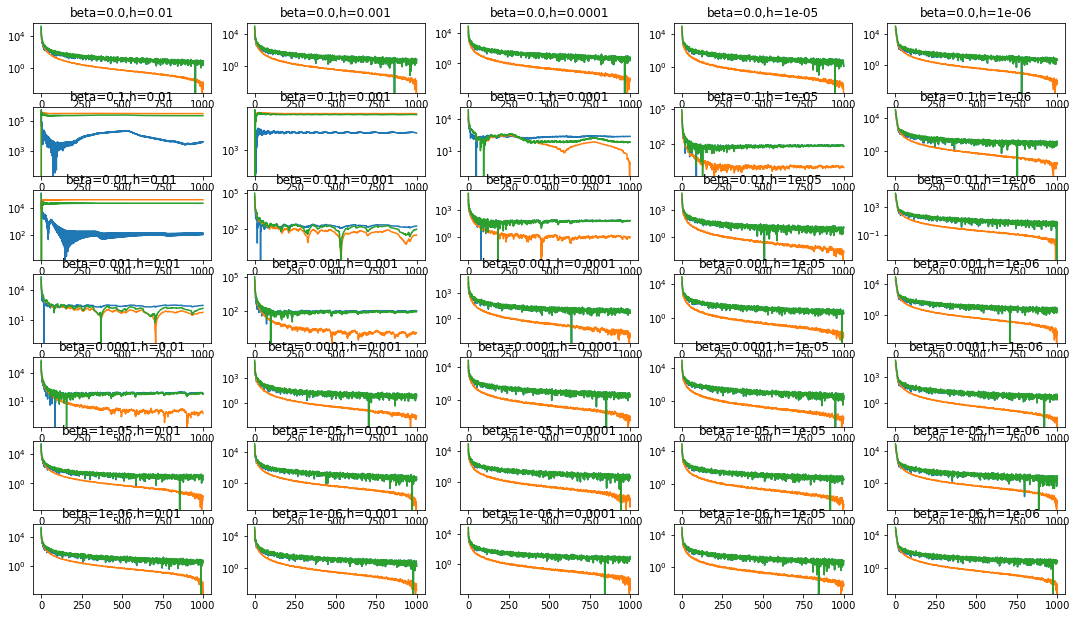

In [74]:
print('Blue - dual values, orange - primal values, green - duality gap')
print('Max_iter =', max_iter)
fig, ax = plt.subplots(nrows=len(beta_range), ncols=len(h_range))
fig.set_size_inches(18.5, 10.5)
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        beta = beta_range[i]
        h = h_range[j]
        
        col.set_title(f'beta={beta},h={h}')
        col.set_yscale('log')
        col.plot(np.arange(len(dual_vals[(beta,h)])), dual_vals[(beta,h)] - np.min(dual_vals[(beta,h)]), label='dual')
        col.plot(np.arange(len(primal_vals[(beta,h)])), primal_vals[(beta,h)] - np.min(primal_vals[(beta,h)]), label='primal')
        col.plot(np.arange(len(results[(beta,h)]['duality_gap_history'])), 
                 results[(beta,h)]['duality_gap_history'] - np.min(results[(beta,h)]['duality_gap_history']), 
                 label='duality gap')

We can note that in many cases duality gap curve is almost the same as the primal values curve.

### Comparison with Frank-Wolfe algorithm

In [75]:
max_iter = 1000

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter': max_iter}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwa', solver_kwargs = solver_kwargs, verbose = False)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))

print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['Free Flow Time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['Capacity']) - 1, end = '\n\n')

# with open('anaheim_result_' + 'fwa' + '_max_iter_' + str(max_iter) + 
#           '_Beckman.pickle', 'wb') as f:
#     pickle.dump(result, f)

Frank-Wolfe without stopping criteria
L_init =  1.0
Elapsed time: 80 sec
Time ratio = 2.910723733762904
Flow excess = 0.8891944444444455



In [76]:
flows['fwa']=result['flows']
times['fwa']=result['times']
iter_nums['fwa']=result['iter_num']
primal_vals['fwa']=result['primal_func_history']

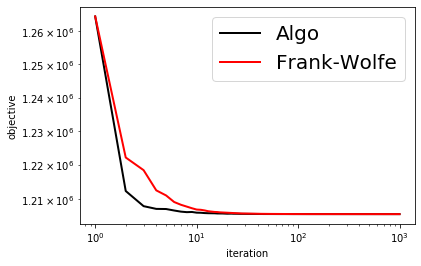

In [86]:
plt.rc('text')

plt.loglog(np.arange(1, len(primal_vals[(0.0001,0.0001)]) + 1), primal_vals[(0.0001,0.0001)], 'black', label = 'Algo', linewidth=2)#, marker='^')
plt.loglog(np.arange(1, len(primal_vals['fwa']) + 1), primal_vals['fwa'], 'red', label = 'Frank-Wolfe', linewidth=2)#, marker='o')

plt.xlabel('iteration')
plt.ylabel('objective')
plt.legend()
legend = plt.legend(loc=0,fontsize=20)
text = legend.get_texts()[1]
props = text.get_font_properties().copy()
text.set_fontproperties(props)
text.set_size(20)

## Conclusion
Our algorithm converges numerically faster than the existing best algorithm Frank-Wolfe.